In [1]:
!pip install --upgrade xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree._classes import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

  Using cached numpy-2.2.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (62 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
file_path = 'car_prices.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


## Data preprocessing

In [4]:
# drop rows with missing values & duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### Column Reformation

In [5]:
df.rename(columns={'make': 'brand', 'body': 'body_type', 'odometer': 'mileage'}, inplace=True)

In [6]:
# dorp 'vin' column as it is not useful for our analysis
df.drop(columns=['vin'], inplace=True)

In [7]:
# calculate the sales year
df['sale_year'] = df['saledate'].str[11:15]
df['sale_year'] = pd.to_numeric(df['sale_year'], errors='coerce').astype('Int64')

In [8]:
df.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014


In [9]:
df.shape

(472325, 16)

### Handling Extrme Values

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


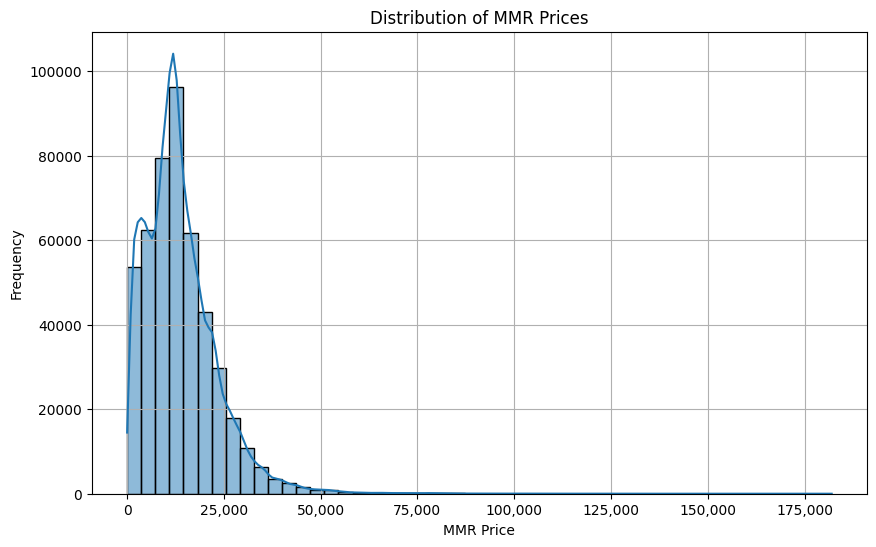

In [10]:
mmr_column = 'mmr'

plt.figure(figsize=(10, 6))
sns.histplot(df[mmr_column].dropna(), bins=50, kde=True)
plt.xlabel("MMR Price")
plt.ylabel("Frequency")
plt.title("Distribution of MMR Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    why choose this threshold?

In [11]:
mmr_column = 'mmr'

low_threshold = df[mmr_column].quantile(0.02)
high_threshold = df[mmr_column].quantile(0.98)

print(f"MMR lowwer {low_threshold:,.0f}")
print(f"MMR higher {high_threshold:,.0f}")

MMR lowwer 1,125
MMR higher 38,100


In [12]:
df['sale_year'].value_counts()

sale_year
2015    435536
2014     36789
Name: count, dtype: Int64

Since all sales are between 2014 & 2015, no need to adjust for inflation, can compare mmr & selling price at the same dollar value.

    why this threshold?

In [13]:
df = df[(df['mmr'] > 500) & (df['mmr'] < 45000)] 

df.shape

(466319, 16)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


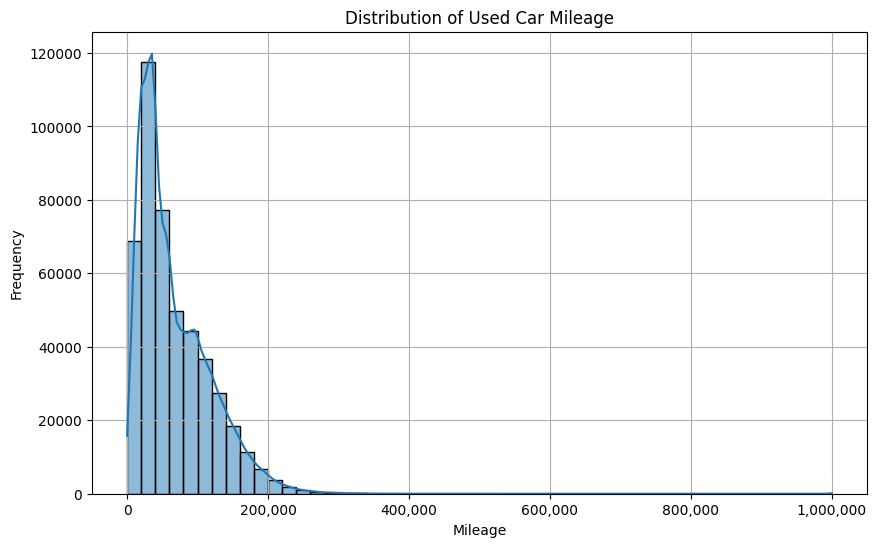

In [14]:
mileage_column = 'mileage'

plt.figure(figsize=(10, 6))
sns.histplot(df[mileage_column].dropna(), bins=50, kde=True)
plt.xlabel("Mileage")
plt.ylabel("Frequency")
plt.title("Distribution of Used Car Mileage")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    again why this threshold

In [15]:
mileage_column = 'mileage'

low_threshold = df[mileage_column].quantile(0.02)
high_threshold = df[mileage_column].quantile(0.98)

print(f"mileage lowwer {low_threshold:,.0f}")
print(f"mileage higher {high_threshold:,.0f}")

mileage lowwer 6,147
mileage higher 194,577


In [16]:
df.shape

(466319, 16)

In [17]:
# new_df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)] 

# new_df.shape

In [18]:
# test_df = df[df['mileage'] > 200000] 
# test_df['mileage'].describe()

In [19]:
# test_df = df[df['mileage'] < 5000] 
# test_df['mileage'].describe()

    For subset having mileage less than 5000, its 25th quartile is still almost 1000, would it be better to decrease the threshold for lower bound?

/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


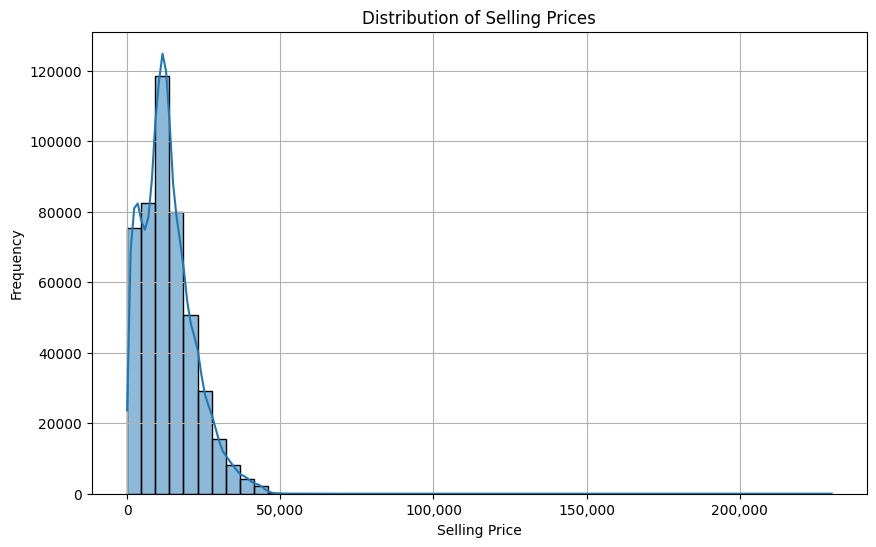

In [20]:
sellingprice_column = 'sellingprice'

plt.figure(figsize=(10, 6))
sns.histplot(df[sellingprice_column].dropna(), bins=50, kde=True)
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.title("Distribution of Selling Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [21]:
price = 'sellingprice'

low_threshold = df[price].quantile(0.02)
high_threshold = df[price].quantile(0.98)

print(f"price lowwer {low_threshold:,.0f}")
print(f"price higher {high_threshold:,.0f}")

price lowwer 900
price higher 35,000


In [22]:
df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 45000)]

df.shape

(454009, 16)

For 'year' column, since manufacturing year cannot exceed sales year, drop any records that does not satisfy this condition.

In [23]:
df = df[df['year'] <= df['sale_year']]

df.shape

(453868, 16)

add a new column 'car_age' that calculate car's age based on sales_year - manufacuring_year

In [24]:
df['car_age'] = df['sale_year'] - df['year']

    need to output a csv file here as the outcome of data preprocessing module

In [25]:
# output df_cleaned to a csv file named 'car_prices_cleaned.csv'
# df_cleaned.to_csv('car_prices_cleaned.csv', index=False)

## MMR Factor Analysis

The Manheim Market Report (MMR) is the premier indicator a vehicle's prices.
  
    **Baseline Model**: Assume MMR properly reflects the current market value of each vahicle, we need to analyze how various factors affect its pricing, giving different makes and models, combined with mileage adjustment, condition adjustment, market class, etc,.


    need to read the preprocessed file after splitting notebook for different modules

In [26]:
# df_cleaned = pd.read_csv('car_prices_cleaned.csv')

In [27]:
df_mmr = df.copy()

In [28]:
df_mmr.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year,car_age
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015,1
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015,0
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,enterprise vehicle exchange / tra / rental / t...,11900.0,9800.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST),2014,0
8,2014,Audi,A4,2.0T Premium Plus quattro,Sedan,automatic,ca,42.0,9557.0,white,black,audi mission viejo,32100.0,32250.0,Thu Dec 18 2014 12:00:00 GMT-0800 (PST),2014,0
9,2014,Chevrolet,Camaro,LT,Convertible,automatic,ca,3.0,4809.0,red,black,d/m auto sales inc,26300.0,17500.0,Tue Jan 20 2015 04:00:00 GMT-0800 (PST),2015,1


### feature engineering

We need to explore what features relevant in impacting the calculation of depreciation rate per mileage.

In [29]:
# selecting relevant features based on empirical knowledge
relevant_features = ['brand','model', 'body_type', 'car_age', 'condition', 'transmission', 'mileage', 'mmr']
df_mmr = df_mmr[relevant_features]
df_mmr.head()

,brand,model,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,3 Series,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,S60,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Cruze,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,A4,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Camaro,Convertible,1,3.0,automatic,4809.0,26300.0


In [30]:
df_mmr['brand'].value_counts().shape

(47,)

In [31]:
df_mmr['model'].value_counts().shape

(706,)

In [32]:
df_mmr['body_type'].value_counts().shape

(82,)

In [33]:
df_mmr['transmission'].value_counts().shape

(2,)

Since different brands have vary different names for model, so the column 'model' itself does not apply to our factor analysis. **Drop it** <br>
Both 'brand' and 'body_type' are high dimensional categorical variables --> use label encoding to convert them to numeric values

In [34]:
df_mmr.drop('model', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Convertible,1,3.0,automatic,4809.0,26300.0


In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# label encoding for categorical features
le = LabelEncoder()
df_mmr['brand'] = le.fit_transform(df_mmr['brand'])
df_mmr['body_type'] = le.fit_transform(df_mmr['body_type'])
df_mmr['transmission'] = le.fit_transform(df_mmr['transmission'])
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,3,34,1,45.0,0,1331.0,31900.0
3,45,34,0,41.0,0,14282.0,27500.0
7,7,34,0,2.0,0,28617.0,11900.0
8,2,34,0,42.0,0,9557.0,32100.0
9,7,8,1,3.0,0,4809.0,26300.0


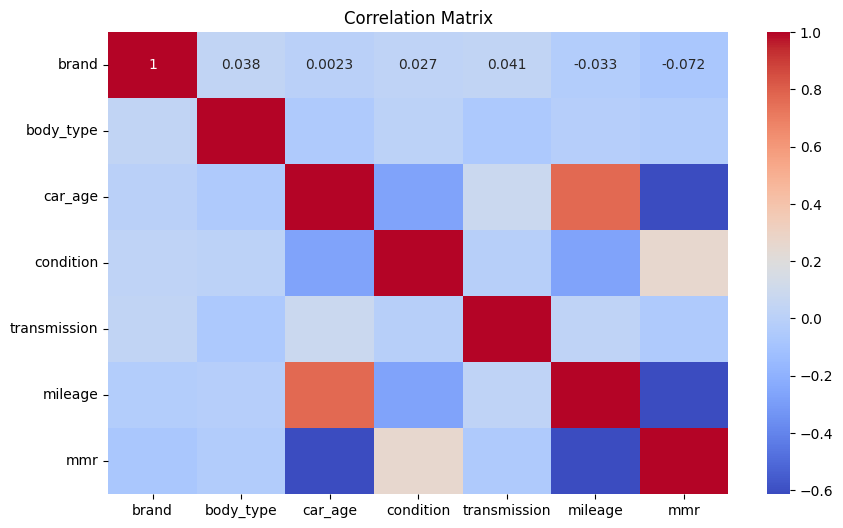

In [37]:
# conduct correlation analysis to remove multicollinearity
corr_matrix = df_mmr.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In this correlation matrix, **'car age' and 'mileage'** show a high correlation, so we need to drop one feature to prevent multicollinearity.
<br>
We decided to select 'mileage' for training  as it best indicate each vehicle's depreciation. 

In [38]:
df_mmr.drop('car_age', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,3,34,45.0,0,1331.0,31900.0
3,45,34,41.0,0,14282.0,27500.0
7,7,34,2.0,0,28617.0,11900.0
8,2,34,42.0,0,9557.0,32100.0
9,7,8,3.0,0,4809.0,26300.0


In [39]:
# standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']] = scaler.fit_transform(df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']])
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,-1.262371,-0.188425,1.061583,-0.186013,-1.298652,2.235826
3,2.066911,-0.188425,0.752880,-0.186013,-1.032008,1.694450
7,-0.945296,-0.188425,-2.256971,-0.186013,-0.736870,-0.224974
8,-1.341640,-0.188425,0.830056,-0.186013,-1.129289,2.260434
9,-0.945296,-1.712004,-2.179795,-0.186013,-1.227044,1.546802


### Model training

I choose decision tree model as a baseline model given the presumption that the depreciation rate is primarily driven by mileage, and I want to explore how other relevant features can impact the depreciation rate

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X, y = df_mmr.drop(columns=['mmr']), df_mmr['mmr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# make sure training data & test data have the same number of features and acceptable number of samples
print(X_train.shape)
print(X_test.shape)

(363094, 5)
(90774, 5)


In [43]:
from sklearn.tree._classes import DecisionTreeRegressor

In [44]:
# train a decision tree model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [45]:
# make predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

**success metrics**: use RMSE to measure the error of predictions on both training & test data

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.02
Model Test RMSE: 0.67


In [47]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, dt.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.06
transmission: 0.00
mileage: 0.58


Results not good, try more complex model.

#### Random forest

In [48]:
# use random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [49]:
# make predictions
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

In [50]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.19
Model Test RMSE: 0.52


In [51]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, rfr.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.07
transmission: 0.00
mileage: 0.57


#### XGBoost

In [53]:
# use xgboost to train a regression model
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [54]:
# make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

In [55]:
# calculate r squared score of the model
train_r2 = xgb.score(X_train, y_train)
test_r2 = xgb.score(X_test, y_test)
print(f"Model Training R^2: {train_r2:.2f}")
print(f"Model Test R^2: {test_r2:.2f}")

Model Training R^2: 0.78
Model Test R^2: 0.77


In [56]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.47
Model Test RMSE: 0.48


In [57]:
# print the coefficient of the xgboost model
for feature, importance in zip(X.columns, xgb.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.19
body_type: 0.22
condition: 0.05
transmission: 0.02
mileage: 0.52


After training with different non-linear tree models, xgboost outperforms other models by yielding a r^2 score of **0.77**  and the smallest RMSE of **0.48** without overfitting. This model shows that the top dominant feature affecting mmr is **'mileage'** with a feature importance of 0.52.

**However, we suspected different brands and models should have stronger impact on the MMR of each vehicle, but we simply label encoded the two columns in our baseline model.**

    In this case, we need to take a deeper dive into the specific brands and models in our dataset, and segment different types of cars (ex.SUV, economics, etc.,) and optimize our model with empirical knowledge.